In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats import iqr
from sklearn import metrics
from scipy.stats import sem
%matplotlib inline

In [17]:
#Functions

# Takes dataframe, intializes two matrices (num_features: number of features and cat_features: feature category)
# returns matrices
def get_cat_num_features(df):
    num_features = []
    cat_features = []
    for col in df.columns:
        if df[col].dtype=="float64" or df[col].dtype=="int64":
            num_features.append(col)
        else:
            cat_features.append(col)
    return num_features, cat_features

# Takes original dataframe (original_dataframe) with identified outlier dataframe (get_outlier_dataframe) 
# and number of columns (dataframe_features)
# rm_outliers boolean allows shortcutting of calling get_outliers command prior 
def remove_outliers(original_dataframe = [], get_outlier_dataframe = [], dataframe_features = [], rm_outliers=False):
    
    if rm_outliers:
        get_outlier_dataframe = get_outliers(original_dataframe,dataframe_features)
    
    for col in get_outlier_dataframe['Feature'].to_list():
        upper = get_outlier_dataframe[get_outlier_dataframe['Feature']== col ]['Upper limit'].values[0]
        lower = get_outlier_dataframe[get_outlier_dataframe['Feature']== col ]['Lower limit'].values[0]
        original_dataframe[col] = np.where(original_dataframe[col]>upper, upper, original_dataframe[col])
        original_dataframe[col] = np.where(original_dataframe[col]<lower, lower, original_dataframe[col])
        
    return original_dataframe


# Takes dataframe and number of columns in datafrae (num_feat)
# Utilizes descriptive statistics (IQR) to identify outliers (1.5 +/- IQR at 25th or 75th percentiles)
# Creates dataframe identifying outlier: column, total outlier count (total), and outliers (upper, lower)
# rm_outlier functions to enable automatic removal of identified outliers via remove_outliers function
def get_outliers(df, num_feat):
    outlier_df = pd.DataFrame(columns=['Feature', 'Total Outliers','Upper limit', 'Lower limit'])
    for col in num_feat:
        lower=np.percentile(df[col],25)-(1.5*iqr(df[col]))
        upper=np.percentile(df[col],75)+(1.5*iqr(df[col]))
        upper_outliers = df[df[col] > upper]
        lower_outliers = df[df[col] < lower]
        total=lower_outliers.shape[0]+upper_outliers.shape[0]
        if (total!=0) and (upper!=0 and lower!=0):
            outlier_df = outlier_df.append({'Feature':col, 'Total Outliers': total,'Upper limit': upper, 'Lower limit':lower}, ignore_index=True)
    
    return outlier_df


In [18]:
data=pd.read_csv('house-prices-advanced-regression-techniques/train.csv',index_col='Id')
data2=pd.read_csv('house-prices-advanced-regression-techniques/test.csv',index_col='Id')
temp=data['SalePrice']
data=data.drop(['SalePrice'],axis=1)
data=pd.concat([data,data2])
data=data.fillna({'Alley':'NA','BsmtQual':'NA','BsmtCond':'NA','BsmtExposure':'NA','BsmtFinType1':'NA','BsmtFinType2':'NA','FireplaceQu':'NA','GarageType':'NA','GarageFinish':'NA','GarageQual':'NA','GarageCond':'NA','PoolQC':'NA','Fence':'NA','MiscFeature':'NA','Exterior2nd':'NA','Functional':'Typ'})
cate=['MSZoning','Exterior1st','MasVnrType','Electrical','KitchenQual','Functional','GarageYrBlt','SaleType']
for item in cate:
    data[item]=data[item].fillna(data[item].value_counts().index[0])
data=data.drop(['Utilities'],axis=1)
data=data.drop(['KitchenAbvGr'],axis=1)
tem=np.where(data['MasVnrType']=='None',0,data['MasVnrArea'])
data['MasVnrArea']=data['MasVnrArea'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType1']=='NA',0,data['BsmtFinSF1'])
data['BsmtFinSF1']=data['BsmtFinSF1'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType2']=='NA',0,data['BsmtFinSF2'])
data['BsmtFinSF2']=data['BsmtFinSF2'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtUnfSF'])
data['BsmtUnfSF']=data['BsmtUnfSF'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtHalfBath'])
data['BsmtHalfBath']=data['BsmtHalfBath'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtFullBath'])
data['BsmtFullBath']=data['BsmtFullBath'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageCars'])
data['GarageCars']=data['GarageCars'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageArea'])
data['GarageArea']=data['GarageArea'].fillna(pd.Series(tem))
data['LotFrontage']=data.groupby('Neighborhood')["LotFrontage"].transform(lambda x: x.fillna(x.median()))
data['TotalBsmtSF']=(data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF'])
data['TotalSF']=data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
data['Total_sqr_footage'] = (data['BsmtFinSF1']+data['BsmtFinSF2']+data['1stFlrSF']+data['2ndFlrSF'])
data['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath'])+data['BsmtFullBath']+(0.5*data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF']+data['3SsnPorch']+data['EnclosedPorch'] + data['ScreenPorch']+data['WoodDeckSF'])
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['OverallCond'] = data['OverallCond'].astype(str)
#data['KitchenAbvGr']=data['KitchenAbvGr'].fillna(data['KitchenAbvGr'].value_counts().index[0])
tem=np.where(data['YrSold']>data['GarageYrBlt'],data['YrSold'],np.where(data['GarageYrBlt']>data['YearRemodAdd'],data['GarageYrBlt'],data['YearRemodAdd']))
data['age']=tem-data['YearBuilt']
data['YearBuilt']=data['YearBuilt'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
od=['MSZoning','LotShape','LandContour','LandSlope','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual', 'GarageCond', 'PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']
dm=['MSSubClass','Street','Alley','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd','MasVnrType','Foundation','Heating']
data=pd.get_dummies(data,columns=dm)

for col in data.select_dtypes('object').columns:
    ce=['YearBuilt','YrSold','GarageYrBlt','YearRemodAdd']
    if col not in ce:
        if col in od:
            le=LabelEncoder()
            data[col]=le.fit_transform(data[col])
        else:
            continue
    else:
        continue
data2=data.iloc[1460:,:]
data=data.iloc[0:1460,:]
data=data.join(temp)
num_feat,cat_feat=get_cat_num_features(data)
# outlier_df = get_outliers(data, num_feat)
# data=remove_outliers(data,outlier_df,num_feat)

In [19]:
c=data.corr()
print(c['SalePrice'].sort_values().tail(11))
x=data.iloc[:,:-1]
y=data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

TotalBsmtSF          0.613581
GarageArea           0.623431
Total_Bathrooms      0.631731
GarageCars           0.640409
Total_sqr_footage    0.708047
GrLivArea            0.708624
TotalSF              0.782260
OverallQual          0.790982
SalePrice            1.000000
MSSubClass_150            NaN
Exterior2nd_NA            NaN
Name: SalePrice, dtype: float64


In [20]:
regressor = LinearRegression()
regressor.fit(x_train[['LotArea','OverallQual','OverallCond','YearRemodAdd','BsmtQual','GarageType','GarageCars','TotalSF','Total_sqr_footage','Total_Bathrooms']],y_train/100000)
y_pred=regressor.predict(x_test[['LotArea','OverallQual','OverallCond','YearRemodAdd','BsmtQual','GarageType','GarageCars','TotalSF','Total_sqr_footage','Total_Bathrooms']])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test/100000, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test/100000, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test/100000, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test/100000, y_pred))
x_2=data2[['LotArea','OverallQual','OverallCond','YearRemodAdd','BsmtQual','GarageType','GarageCars','TotalSF','Total_sqr_footage','Total_Bathrooms']]
y_pred=regressor.predict(x_2)
my_submission = pd.DataFrame({'Id': data2.index, 'SalePrice': (100000*y_pred)})
my_submission.to_csv('submission.csv', index=False)

Mean Absolute Error: 0.24988719421838734
Mean Squared Error: 0.24811552462075645
Root Mean Squared Error: 0.4981119599254333
R-squared Error: 0.6407168908765069


In [21]:
dt = DecisionTreeRegressor()
dt.fit(x_train[['LotArea','OverallQual','OverallCond','YearRemodAdd','BsmtQual','GarageType','GarageCars','TotalSF','Total_sqr_footage','Total_Bathrooms']],y_train/100000)
y_pred=dt.predict(x_test[['LotArea','OverallQual','OverallCond','YearRemodAdd','BsmtQual','GarageType','GarageCars','TotalSF','Total_sqr_footage','Total_Bathrooms']])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test/100000, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test/100000, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test/100000, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test/100000, y_pred))

Mean Absolute Error: 0.25865726027397257
Mean Squared Error: 0.13759135165068495
Root Mean Squared Error: 0.3709330824430263
R-squared Error: 0.8007611628287992


In [22]:
data.head()

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,3,65.0,8450,3,3,0,7,4,2003,2003,...,0,0,0,0,1,0,0,0,0,208500
2,3,80.0,9600,3,3,0,6,7,1976,1976,...,0,0,0,0,1,0,0,0,0,181500
3,3,68.0,11250,0,3,0,7,4,2001,2002,...,0,0,0,0,1,0,0,0,0,223500
4,3,60.0,9550,0,3,0,7,4,1915,1970,...,0,0,0,0,1,0,0,0,0,140000
5,3,84.0,14260,0,3,0,8,4,2000,2000,...,0,0,0,0,1,0,0,0,0,250000


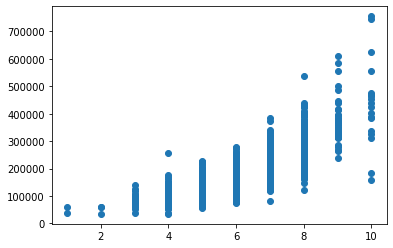

In [31]:
plt.scatter(data['OverallQual'],data['SalePrice'])

In [34]:
qual = data['OverallQual'];
sales = data['SalePrice'];

In [78]:
standardError

[10850.0,
 8229.666666666668,
 5520.531497045227,
 2694.625413050428,
 1360.4779405463237,
 1866.178932415547,
 2489.6325636218016,
 4929.907338267869,
 12394.80546376115,
 37661.80142074739]

In [81]:
graphicalDF = pd.DataFrame(qualAvgSale,standardError)

In [89]:
-1*.standardError

SyntaxError: invalid syntax (<ipython-input-89-5d676388fc1b>, line 1)

ValueError: The lengths of the data (10) and the error 0 do not match

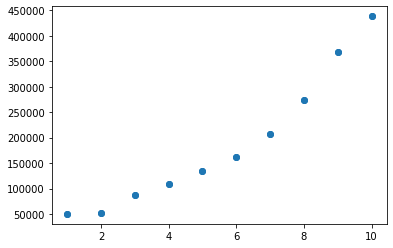

In [85]:
qualNumIndex = []
qualAvgSale = []
standardError = []

for x in np.unique(qual):
    qualValues = sales[qual == x] 
    avgVal = sum(qualValues/len(qualValues))
    qualAvgSale.append(avgVal)
    qualNumIndex.append(x)
    standardError.append(sem(qualValues))
    

plt.scatter(qualNumIndex,qualAvgSale)
y_error = [-1*(standardError), standardError]
plt.errorbar(qualNumIndex, qualAvgSale, yerr=y_error, fmt="o")

In [62]:
qualAvgSale

,0
Sale,Quality
"[50150.0, 51770.333333333336, 87473.75, 108420.65517241384, 133523.34760705288, 161603.03475935815, 207716.42319749214, 274735.53571428586, 367513.0232558139, 438588.3888888889]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"


{'whiskers': [<matplotlib.lines.Line2D at 0x2662b76ca90>,
 'caps': [<matplotlib.lines.Line2D at 0x2662b7790a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2662b76c760>],
 'medians': [<matplotlib.lines.Line2D at 0x2662b779790>],
 'fliers': [<matplotlib.lines.Line2D at 0x2662b779b20>],
 'means': []}

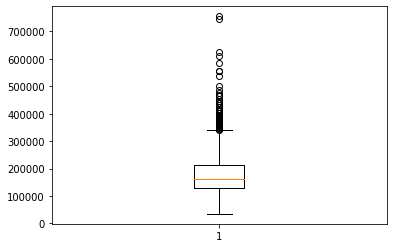

In [24]:
plt.boxplot(data['SalePrice'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2662b821d90>,
 'caps': [<matplotlib.lines.Line2D at 0x2662b8304f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2662b821b50>],
 'medians': [<matplotlib.lines.Line2D at 0x2662b830c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x2662b830fd0>],
 'means': []}

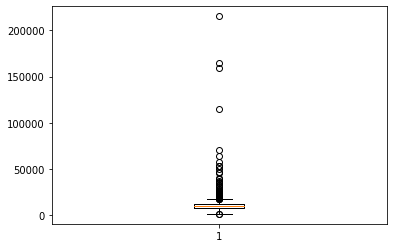

In [25]:
plt.boxplot(data['LotArea'])